<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#5d3a8e; font-size:40px'> Latent Dirichlet Allocation(LDA) for Topic Modelling (Python)</h1>
</div>

<div align="center">
<h3>Using the Amazon fine food reviews dataset</h3>
<a>Link:https://www.kaggle.com/snap/amazon-fine-food-reviews </a>
<h6>For performing LDA based topic modelling ,  I will be using the gensim package for LDA topic modelling &  pyLDAvis for visualization of LDA topic model</h6>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 1. Import Packages</h2>
</div>

The core packages used in this tutorial are `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`,`numpy` and `pandas` for data handling and visualization. Let’s import them.

In [2]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import nltk
# nltk.download('stopwords')

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Reading the data</h2>
</div>

In [3]:
review_data= pd.read_csv("Reviews.csv")

# print(review_data.head(2))

review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print("Length of the data is :" , len(review_data))

print('Unique Products : ' , len(review_data.groupby('ProductId')))


print('Unique Users : ', len(review_data.groupby('UserId')))


Length of the data is : 568454
Unique Products :  74258
Unique Users :  256059



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Cleaning Text</h2>
</div>

In [5]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()


In [7]:
review_data.dropna(axis = 0, how ='any',inplace=True) 


review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')

print(review_data['Score'].value_counts())
print(len(review_data))

print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))


-------Dataset --------
Score
5    363102
4     80654
1     52264
3     42638
2     29743
Name: count, dtype: int64
568401
-------------------------
No of Short reviews
373279




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Pre-Process the Text</h2>
</div>


In [8]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Lemmetization
</h2>
</div>


In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output


In [10]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])

print('-'*60)

tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

dark roast coffee notice buying like dark roast coffee seems burned strong like starbucks coffee probably like coffee took taste dumped entire smell strong reminds nasty cigar
------------------------------------------------------------
['coffee', 'notice', 'buying', 'dark', 'roast', 'coffee', 'strong', 'starbuck', 'coffee', 'coffee', 'taste', 'entire', 'smell', 'strong', 'nasty', 'cigar']





<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6.  Create vocabulary dictionary and document term matrix
</h2>
</div>



In [11]:
dictionary = corpora.Dictionary(tokenized_reviews)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]






<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>7. LemmetizationCreating the object for LDA model using gensim library
</div>


In [12]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                num_topics=10, 
                random_state=100,
                chunksize=1000, 
                passes=50,
                iterations=100)

In [13]:
lda_model.print_topics()

[(0,
  '0.051*"butter" + 0.035*"bread" + 0.031*"peanut" + 0.026*"recipe" + 0.023*"soup" + 0.021*"can" + 0.017*"bone" + 0.012*"mint" + 0.012*"coat" + 0.012*"restaurant"'),
 (1,
  '0.050*"bar" + 0.045*"vanilla" + 0.039*"smooth" + 0.036*"tea" + 0.035*"green" + 0.033*"blend" + 0.032*"potato" + 0.024*"breakfast" + 0.019*"black" + 0.015*"brew"'),
 (2,
  '0.034*"taste" + 0.033*"flavor" + 0.031*"good" + 0.031*"sugar" + 0.030*"sweet" + 0.028*"water" + 0.024*"product" + 0.019*"drink" + 0.019*"great" + 0.018*"calorie"'),
 (3,
  '0.038*"organic" + 0.032*"fruit" + 0.028*"cereal" + 0.024*"rice" + 0.023*"free" + 0.021*"honey" + 0.020*"cracker" + 0.020*"healthy" + 0.020*"corn" + 0.019*"whole"'),
 (4,
  '0.076*"food" + 0.047*"product" + 0.018*"good" + 0.018*"year" + 0.018*"time" + 0.015*"great" + 0.014*"month" + 0.014*"cat" + 0.012*"happy" + 0.011*"problem"'),
 (5,
  '0.070*"chocolate" + 0.041*"cookie" + 0.028*"snack" + 0.027*"candy" + 0.026*"great" + 0.020*"good" + 0.018*"popcorn" + 0.017*"gift" + 0.0




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8. Visualize the topics
</h2>
</div>


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.130060 -0.041710       1        1  16.147998
6      0.117104  0.011966       2        1  14.534630
2      0.117568  0.071181       3        1  13.666319
9      0.135511 -0.092528       4        1  12.723775
7      0.113345  0.056425       5        1  11.064942
8      0.083072 -0.097162       6        1  10.117589
5      0.050985 -0.024581       7        1   7.215331
3     -0.085029  0.147180       8        1   5.831310
0     -0.306800  0.258877       9        1   4.615799
1     -0.355816 -0.289647      10        1   4.082308, topic_info=           Term          Freq         Total Category  logprob  loglift
28       coffee  31675.000000  31675.000000  Default  30.0000  30.0000
47         food  25823.000000  25823.000000  Default  29.0000  29.0000
120      flavor  31968.000000  31968.000000  Default  28.0000  28.0000
42        price  13862.000000  13862.000000  Default  27.0000  27.0000
171       store  12634.000000  12634.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
735       black   1532.250910   3312.980849  Topic10  -3.9520   2.4274
2496      share    510.133198    628.082138  Topic10  -5.0519   2.9905
865       scent    513.356160    652.100462  Topic10  -5.0456   2.9593
297   packaging    558.138244   1835.521736  Topic10  -4.9619   2.0080
421    favorite    530.960622   8299.691503  Topic10  -5.0118   0.4492

[539 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
680       1  0.163930    able
680       2  0.061651    able
680       4  0.448890    able
680       5  0.070743    able
680       6  0.254561    able
...     ...       ...     ...
223       5  0.039320    year
223       6  0.107014    year
223       7  0.070136    year
3750      9  0.998108  yellow
2987     10  0.997977   young

[805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 10, 8, 9, 6, 4, 1, 2])




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>9. Measuring how good the model is. lower the better.
</h2>
</div>


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))


### Computing Coherence Score


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>10. Computing Coherence Score
</h2>
</div>


In [16]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42386054991557176




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>11. Method to find optimal number of topics 
</h2>
</div>


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>12.  Viualizatoin with Graph

</h2>
</div>


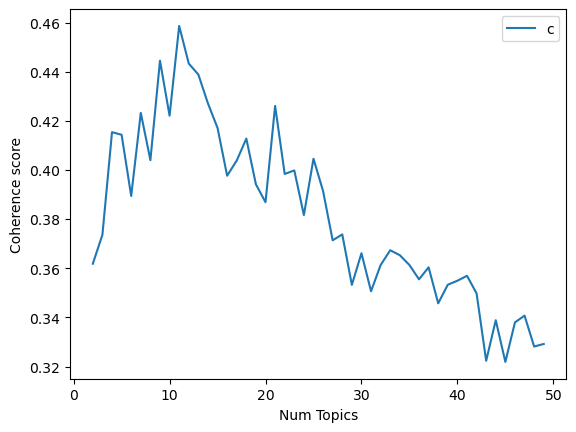

In [19]:
limit=50; start=2; step=1;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# Print the coherence scores
plt.show()




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>13.Printing the coherence scores
</h2>
</div>


In [20]:

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.3618
Num Topics = 3  has Coherence Value of 0.3736
Num Topics = 4  has Coherence Value of 0.4154
Num Topics = 5  has Coherence Value of 0.4143
Num Topics = 6  has Coherence Value of 0.3894
Num Topics = 7  has Coherence Value of 0.4232
Num Topics = 8  has Coherence Value of 0.404
Num Topics = 9  has Coherence Value of 0.4445
Num Topics = 10  has Coherence Value of 0.4221
Num Topics = 11  has Coherence Value of 0.4586
Num Topics = 12  has Coherence Value of 0.4433
Num Topics = 13  has Coherence Value of 0.4388
Num Topics = 14  has Coherence Value of 0.4271
Num Topics = 15  has Coherence Value of 0.4171
Num Topics = 16  has Coherence Value of 0.3977
Num Topics = 17  has Coherence Value of 0.4038
Num Topics = 18  has Coherence Value of 0.4128
Num Topics = 19  has Coherence Value of 0.3941
Num Topics = 20  has Coherence Value of 0.3869
Num Topics = 21  has Coherence Value of 0.4261
Num Topics = 22  has Coherence Value of 0.3984
Num Topics = 23  has C



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>14. Selecting the model and printing the topics
</h2>
</div>



In [21]:
optimal_model = model_list[7]

model_topics = optimal_model.show_topics(formatted=False)

optimal_model.print_topics(num_words=10)

[(0,
  '0.029*"good" + 0.029*"great" + 0.022*"product" + 0.019*"flavor" + 0.014*"taste" + 0.014*"energy" + 0.013*"popcorn" + 0.013*"cheese" + 0.012*"cracker" + 0.012*"snack"'),
 (1,
  '0.121*"coffee" + 0.032*"flavor" + 0.029*"good" + 0.023*"strong" + 0.019*"taste" + 0.014*"bean" + 0.013*"great" + 0.012*"green" + 0.011*"smooth" + 0.010*"blend"'),
 (2,
  '0.039*"product" + 0.027*"time" + 0.022*"year" + 0.018*"order" + 0.018*"good" + 0.018*"month" + 0.015*"great" + 0.015*"amazon" + 0.013*"store" + 0.011*"week"'),
 (3,
  '0.037*"price" + 0.031*"store" + 0.026*"great" + 0.025*"good" + 0.016*"amazon" + 0.014*"grocery" + 0.014*"local" + 0.014*"product" + 0.012*"pack" + 0.011*"time"'),
 (4,
  '0.037*"flavor" + 0.033*"good" + 0.022*"sauce" + 0.022*"candy" + 0.021*"bar" + 0.019*"sweet" + 0.019*"great" + 0.019*"taste" + 0.015*"texture" + 0.015*"little"'),
 (5,
  '0.054*"treat" + 0.045*"chip" + 0.029*"cookie" + 0.027*"dog" + 0.020*"salt" + 0.020*"small" + 0.017*"great" + 0.016*"size" + 0.016*"good




<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>15. Visualize the topics
</h2>
</div>


In [22]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.201533  0.060891       1        1  13.713952
3     -0.130406  0.033632       2        1  13.054216
1      0.177726  0.016723       3        1  13.005041
8     -0.062656  0.017953       4        1  12.945062
6      0.198809  0.045674       5        1  12.692364
0      0.018194 -0.005922       6        1   9.554657
5     -0.120700 -0.221833       7        1   9.117399
4      0.131341 -0.143319       8        1   8.941079
7     -0.010775  0.196201       9        1   6.976230, topic_info=          Term          Freq         Total Category  logprob  loglift
28      coffee  30961.000000  30961.000000  Default  30.0000  30.0000
47        food  22150.000000  22150.000000  Default  29.0000  29.0000
174      treat   9675.000000   9675.000000  Default  28.0000  28.0000
934       chip   7952.000000   7952.000000  Default  27.0000  27.0000
120     flavor  32944.000000  32944.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
51     regular    945.274539   5603.040027   Topic9  -4.9709   0.8831
709     health    714.969413   2859.336246   Topic9  -5.2501   1.2766
166      local    812.335980   6015.909709   Topic9  -5.1225   0.6604
23        well    848.490609   8553.720002   Topic9  -5.0789   0.3520
720  chocolate    836.426185  11186.302704   Topic9  -5.0932   0.0694

[662 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1372      7  0.998222   absolute
4959      7  0.997987   addicted
2258      2  0.932305  addictive
2258      7  0.065851  addictive
1615      1  0.037618  afternoon
...     ...       ...        ...
223       6  0.026192       year
223       7  0.049613       year
223       8  0.028878       year
223       9  0.057085       year
2506      9  0.998179      yeast

[1769 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 9, 7, 1, 6, 5, 8])


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 16.  Saving to PDF
</h2>
</div>


In [8]:
!jupyter nbconvert --to webpdf --allow-chromium-download Topic_Modeling_Using_LDA.ipynb

[NbConvertApp] Converting notebook Topic_Modeling_Using_LDA.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 399933 bytes to Topic_Modeling_Using_LDA.pdf
